In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
file_path = r"C:\Users\gigan\OneDrive\Desktop\NYU\Spring 2025\Projects\IAQF\IAQF_masterfile_values.xlsx"

In [3]:
df_returns = pd.read_excel(file_path, sheet_name="Return", parse_dates=["Date"])
df_weights = pd.read_excel(file_path, sheet_name="Weights", parse_dates=["Date"])
df_beta = pd.read_excel(file_path, sheet_name="Beta", parse_dates=["Date"])

def clean_ticker_names(df):
    # Remove " UN Equity" or " UW Equity" at the end of column names using a regex pattern.
    df.columns = df.columns.str.replace(r' (UN|UW) Equity$', '', regex=True)
    # Strip any leading/trailing whitespace for safety.
    df.columns = df.columns.str.strip()
    return df

# Apply the cleaning function to all dataframes
df_returns = clean_ticker_names(df_returns)
df_weights = clean_ticker_names(df_weights)
df_beta = clean_ticker_names(df_beta)

df_returns.set_index("Date", inplace=True)
df_weights.set_index("Date", inplace=True)
df_beta.set_index("Date", inplace=True)

m7_tickers = ["NVDA", "META", "TSLA", "AMZN", "GOOGL", "MSFT", "AAPL"]

# Determine all tickers present in the Beta data
all_tickers = df_beta.columns.tolist()

# Identify the non-Magnificent 7 tickers.
other_tickers = [ticker for ticker in all_tickers if ticker not in m7_tickers]

In [4]:
# Compute the index beta on each day as the weighted average of individual betas.
# (Assumes that the weights sum to 1 for each day.)
df_index_beta = (df_weights[all_tickers] * df_beta[all_tickers]).sum(axis=1)

# Compute the contribution from the Magnificent 7.
df_m7_beta = (df_weights[m7_tickers] * df_beta[m7_tickers]).sum(axis=1)

# And the contribution from the remaining stocks.
df_others_beta = (df_weights[other_tickers] * df_beta[other_tickers]).sum(axis=1)

# Combine these into a single DataFrame for analysis.
df_analysis = pd.DataFrame({
    "Index_Beta": df_index_beta,
    "M7_Beta": df_m7_beta,
    "Others_Beta": df_others_beta,
    "M7_Ratio": df_m7_beta / df_index_beta  # Fraction of index beta driven by the Magnificent 7
})

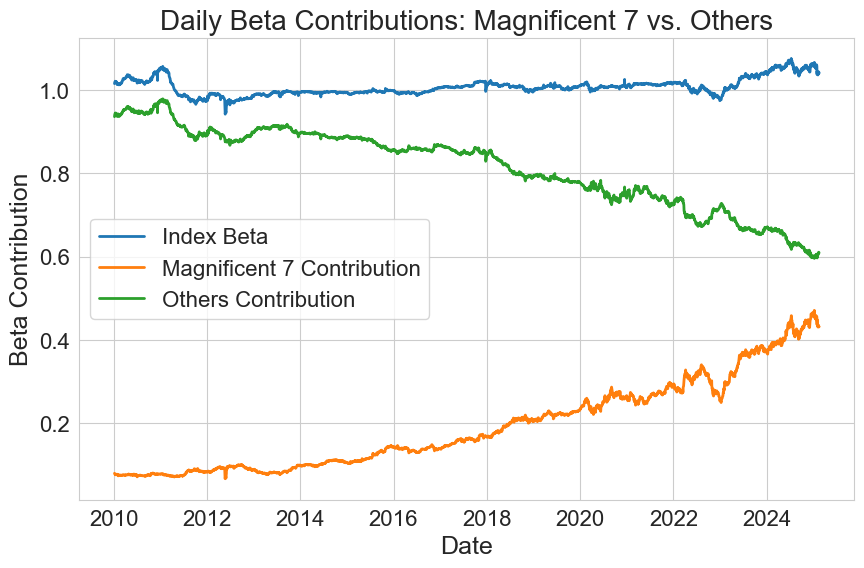

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_analysis.index, df_analysis["Index_Beta"], label="Index Beta", linewidth=2)
ax.plot(df_analysis.index, df_analysis["M7_Beta"], label="Magnificent 7 Contribution", linewidth=2)
ax.plot(df_analysis.index, df_analysis["Others_Beta"], label="Others Contribution", linewidth=2)
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Beta Contribution", fontsize=18)
ax.set_title("Daily Beta Contributions: Magnificent 7 vs. Others", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", fontsize=16)
ax.grid(True)
plt.show()


In [6]:
# %% [code]
# Compute the daily return for the entire index as the weighted average of individual returns.
df_index_return = (df_weights[all_tickers] * df_returns[all_tickers]).sum(axis=1)

# Compute the daily return contribution from the Magnificent 7.
df_m7_return = (df_weights[m7_tickers] * df_returns[m7_tickers]).sum(axis=1)

# Compute the daily return contribution from the remaining stocks.
df_others_return = (df_weights[other_tickers] * df_returns[other_tickers]).sum(axis=1)

# %% [code]
# Convert daily returns to cumulative returns.
# The cumulative return is calculated as the cumulative product of (1 + daily return) minus 1.
cum_index_return = (1 + df_index_return).cumprod() - 1
cum_m7_return = (1 + df_m7_return).cumprod() - 1
cum_others_return = (1 + df_others_return).cumprod() - 1

# Create a DataFrame to combine these series.
df_analysis_return = pd.DataFrame({
    "Index_Return": cum_index_return,
    "M7_Return": cum_m7_return,
    "Others_Return": cum_others_return,
    "M7_Ratio": cum_m7_return / cum_index_return  # Fraction of index cumulative return driven by the Mag7.
})

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Suppose you already have a DataFrame (df_attr) from your log-return decomposition:
# It has columns "Mag7_Contribution (%)" and "Others_Contribution (%)" for each year,
# which might not add exactly to 100.
#
# For example, df_attr might look like:
#         Index_Return (%)  Mag7_Contribution (%)  Others_Contribution (%)
# 2010             10.78                   8.90                    93.23
# 2015              1.08                 258.19                  -134.27
# 2020             20.13                  72.62                    37.53
# ... (and so on)

# For demonstration, let’s assume df_attr is already defined (with a DateTime index converted to year)
# If df_attr.index is datetime, convert it to year:
# df_attr.index = df_attr.index.year

# --- Step 1: Normalize the contributions so that for each year they sum to 100%.
# We have to be careful when the total is zero or negative.
# One simple approach (when the raw sum is not zero) is:
df_attr["Total_Contribution"] = df_attr["Mag7_Contribution (%)"] + df_attr["Others_Contribution (%)"]

# To avoid division issues, we'll only normalize if Total_Contribution != 0.
# Otherwise, we can leave the raw values (or set them to NaN).
df_attr["Mag7_Contribution_Norm (%)"] = np.where(
    df_attr["Total_Contribution"] != 0,
    (df_attr["Mag7_Contribution (%)"] / df_attr["Total_Contribution"]) * 100,
    np.nan
)
df_attr["Others_Contribution_Norm (%)"] = 100 - df_attr["Mag7_Contribution_Norm (%)"]

# --- Step 2: Plot a stacked bar chart using the normalized values.
plt.figure(figsize=(12, 6))
plt.bar(df_attr.index, df_attr["Mag7_Contribution_Norm (%)"],
        label="Magnificent 7", color="red", edgecolor='black')
plt.bar(df_attr.index, df_attr["Others_Contribution_Norm (%)"],
        bottom=df_attr["Mag7_Contribution_Norm (%)"],
        label="Others", color="green", edgecolor='black')

plt.xlabel("Year")
plt.ylabel("Normalized Contribution (%)")
plt.title("Annual Attribution of Index Return:\nMagnificent 7 vs. Others (Normalized)")
plt.ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(100))

# Annotate each stacked bar with the normalized percentages.
for year in df_attr.index:
    mag7_val = df_attr.loc[year, "Mag7_Contribution_Norm (%)"]
    others_val = df_attr.loc[year, "Others_Contribution_Norm (%)"]
    plt.text(year, mag7_val / 2, f"{mag7_val:.1f}%", ha="center", va="center",
             color="white", fontsize=10, fontweight="bold")
    plt.text(year, mag7_val + others_val / 2, f"{others_val:.1f}%", ha="center", va="center",
             color="white", fontsize=10, fontweight="bold")
    
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Optionally, display the normalized attribution table.
display(df_attr[["Index_Return (%)", "Mag7_Contribution_Norm (%)", "Others_Contribution_Norm (%)"]].round(2))


NameError: name 'df_attr' is not defined

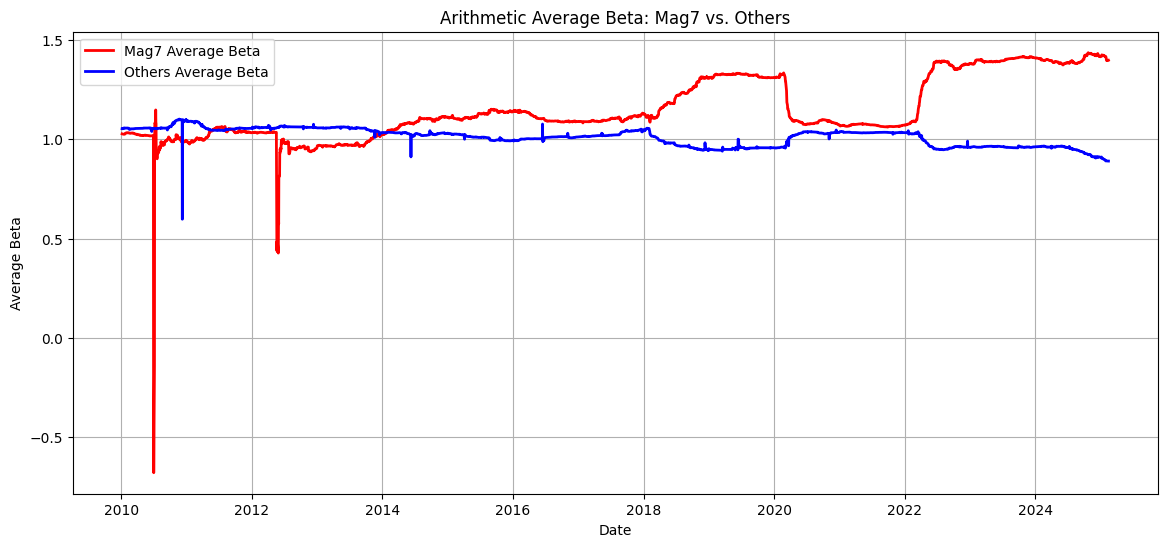

In [ ]:
# %% [code]
import matplotlib.pyplot as plt

# Compute the arithmetic (unweighted) daily average beta for the Magnificent 7.
avg_m7_beta = df_beta[m7_tickers].mean(axis=1)

# Compute the arithmetic (unweighted) daily average beta for the remaining stocks.
avg_others_beta = df_beta[other_tickers].mean(axis=1)

# Combine these into a single DataFrame for easier plotting.
df_avg_beta = pd.DataFrame({
    "Mag7_Avg_Beta": avg_m7_beta,
    "Others_Avg_Beta": avg_others_beta
})

# %% [code]
# Plot the time series of the average betas for Mag7 and Others.
plt.figure(figsize=(14,6))
plt.plot(df_avg_beta.index, df_avg_beta["Mag7_Avg_Beta"], label="Mag7 Average Beta", color="red", linewidth=2)
plt.plot(df_avg_beta.index, df_avg_beta["Others_Avg_Beta"], label="Others Average Beta", color="blue", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Average Beta")
plt.title("Arithmetic Average Beta: Mag7 vs. Others")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
import random
import statsmodels.api as sm

# Ensure reproducibility
random.seed(42)

# Select 20 random tickers from the non-Mag7 list.
# 'other_tickers' should be defined earlier as the list of tickers not in m7_tickers.
sampled_tickers = random.sample(other_tickers, 20)

def compute_beta_for_ticker(ticker, market_ret):
    """
    Compute beta for a given ticker using the provided market return series.
    company_ret: daily returns for the ticker
    market_ret: daily returns for the market proxy (Series)
    Returns the estimated beta (slope coefficient).
    """
    company_ret = df_returns[ticker]
    # Align the series and drop missing values
    df_temp = pd.concat([company_ret, market_ret], axis=1).dropna()
    # Assume the first column is the company's returns and the second is the market returns.
    X = df_temp.iloc[:, 1]
    y = df_temp.iloc[:, 0]
    # Add a constant for the intercept.
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    # Retrieve the slope parameter (beta) using iloc to avoid KeyErrors.
    return model.params.iloc[1]

# Initialize dictionaries to store betas for each ticker.
betas_full = {}
betas_no_mag7 = {}

for ticker in sampled_tickers:
    beta_full = compute_beta_for_ticker(ticker, df_index_return)
    beta_no_mag7 = compute_beta_for_ticker(ticker, df_others_return)
    betas_full[ticker] = beta_full
    betas_no_mag7[ticker] = beta_no_mag7

# Compute average beta for the sampled tickers under each market proxy.
avg_beta_full = sum(betas_full.values()) / len(betas_full)
avg_beta_no_mag7 = sum(betas_no_mag7.values()) / len(betas_no_mag7)

print("Average beta for non-Mag7 stocks (using full index): {:.3f}".format(avg_beta_full))
print("Average beta for non-Mag7 stocks (using index without Mag7): {:.3f}".format(avg_beta_no_mag7))


Average beta for non-Mag7 stocks (using full index): 1.031
Average beta for non-Mag7 stocks (using index without Mag7): 1.350


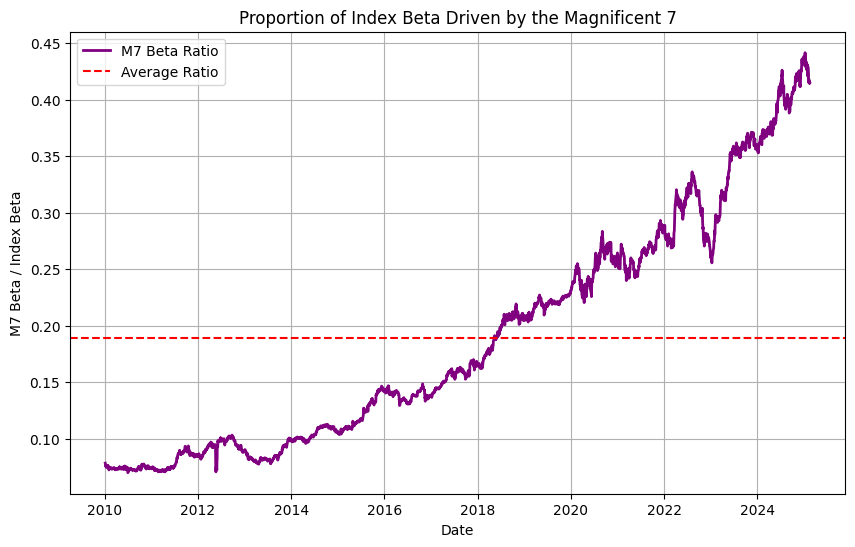

In [ ]:
# Plot the ratio of the M7 contribution to the total index beta.
plt.figure(figsize=(10, 6))
plt.plot(df_analysis.index, df_analysis["M7_Ratio"], label="M7 Beta Ratio", color='purple', linewidth=2)
plt.axhline(y=df_analysis["M7_Ratio"].mean(), color='red', linestyle='--', label="Average Ratio")
plt.xlabel("Date")
plt.ylabel("M7 Beta / Index Beta")
plt.title("Proportion of Index Beta Driven by the Magnificent 7")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Summary statistics for beta contributions
beta_stats = pd.DataFrame({
    "Index_Beta": [df_analysis["Index_Beta"].mean(), df_analysis["Index_Beta"].std()],
    "M7_Beta": [df_analysis["M7_Beta"].mean(), df_analysis["M7_Beta"].std()],
    "Others_Beta": [df_analysis["Others_Beta"].mean(), df_analysis["Others_Beta"].std()]
}, index=["Mean", "Std"])
print("Beta Summary Statistics:")
print(beta_stats)

Beta Summary Statistics:
      Index_Beta   M7_Beta  Others_Beta
Mean    1.007557  0.191632     0.815925
Std     0.025921  0.106348     0.095867



Significant Tesla drop events in 2024:
Date
2024-01-25   -0.121253
2024-03-04   -0.071555
2024-04-15   -0.055949
2024-04-30   -0.055501
2024-07-11   -0.084441
2024-07-24   -0.123346
2024-08-01   -0.065541
2024-08-22   -0.056479
2024-09-06   -0.084459
2024-10-11   -0.087825
2024-11-12   -0.061457
2024-11-14   -0.057716
2024-12-18   -0.082795
Name: TSLA, dtype: float64


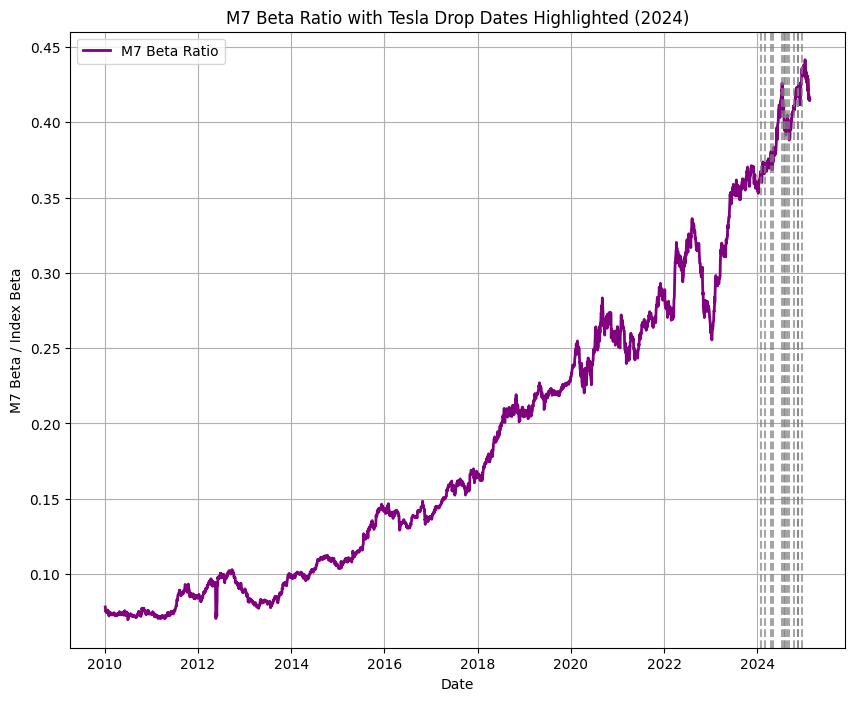

In [ ]:
# A closer look at Tesla's performance in 2024:
if "TSLA" in df_returns.columns:
    tsla_returns = df_returns["TSLA"]
    # Define a threshold for a "significant" drop, e.g., daily return less than -5%.
    tsla_drop_events = tsla_returns[(tsla_returns.index.year == 2024) & (tsla_returns < -0.05)]
    print("\nSignificant Tesla drop events in 2024:")
    print(tsla_drop_events)

    # Optionally, highlight these dates on the M7 beta ratio plot.
    plt.figure(figsize=(10, 8))
    plt.plot(df_analysis.index, df_analysis["M7_Ratio"], label="M7 Beta Ratio", color='purple', linewidth=2)
    for drop_date in tsla_drop_events.index:
        plt.axvline(x=drop_date, color='gray', linestyle='--', alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("M7 Beta / Index Beta")
    plt.title("M7 Beta Ratio with Tesla Drop Dates Highlighted (2024)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
vol_market = vol_market.sort_index()
vol_mag7 = vol_mag7.sort_index()

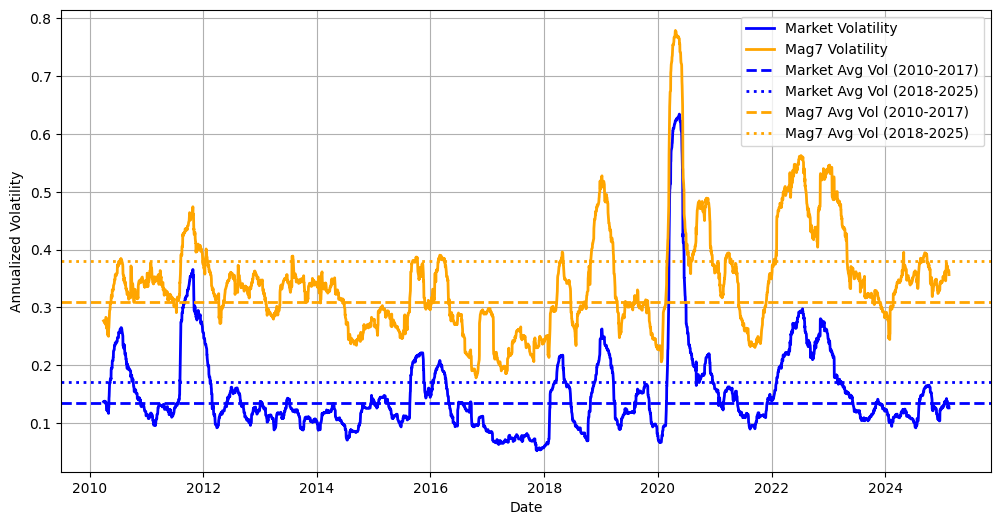

In [ ]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd

# Ensure the indices are datetime and sorted.
vol_market.index = pd.to_datetime(vol_market.index)
vol_mag7.index = pd.to_datetime(vol_mag7.index)
vol_market = vol_market.sort_index()
vol_mag7 = vol_mag7.sort_index()

# Define period boundaries as Timestamps.
period1_start = pd.to_datetime('2010-01-01')
period1_end   = pd.to_datetime('2017-12-31')
period2_start = pd.to_datetime('2018-01-01')
period2_end   = pd.to_datetime('2025-12-31')

# Use boolean masks to compute average volatility for each period.
mask1_market = (vol_market.index >= period1_start) & (vol_market.index <= period1_end)
mask2_market = (vol_market.index >= period2_start) & (vol_market.index <= period2_end)
mask1_mag7   = (vol_mag7.index >= period1_start) & (vol_mag7.index <= period1_end)
mask2_mag7   = (vol_mag7.index >= period2_start) & (vol_mag7.index <= period2_end)

avg_vol_market_period1 = vol_market.loc[mask1_market].mean()
avg_vol_market_period2 = vol_market.loc[mask2_market].mean()
avg_vol_mag7_period1   = vol_mag7.loc[mask1_mag7].mean()
avg_vol_mag7_period2   = vol_mag7.loc[mask2_mag7].mean()

plt.figure(figsize=(12,6))
plt.plot(vol_market.index, vol_market, label="Market Volatility", color="blue", linewidth=2)
plt.plot(vol_mag7.index, vol_mag7, label="Mag7 Volatility", color="orange", linewidth=2)
plt.axhline(avg_vol_market_period1, color="blue", linestyle="--", linewidth=2, label="Market Avg Vol (2010-2017)")
plt.axhline(avg_vol_market_period2, color="blue", linestyle=":", linewidth=2, label="Market Avg Vol (2018-2025)")
plt.axhline(avg_vol_mag7_period1, color="orange", linestyle="--", linewidth=2, label="Mag7 Avg Vol (2010-2017)")
plt.axhline(avg_vol_mag7_period2, color="orange", linestyle=":", linewidth=2, label="Mag7 Avg Vol (2018-2025)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend(loc="best")
plt.grid(True)
plt.show()


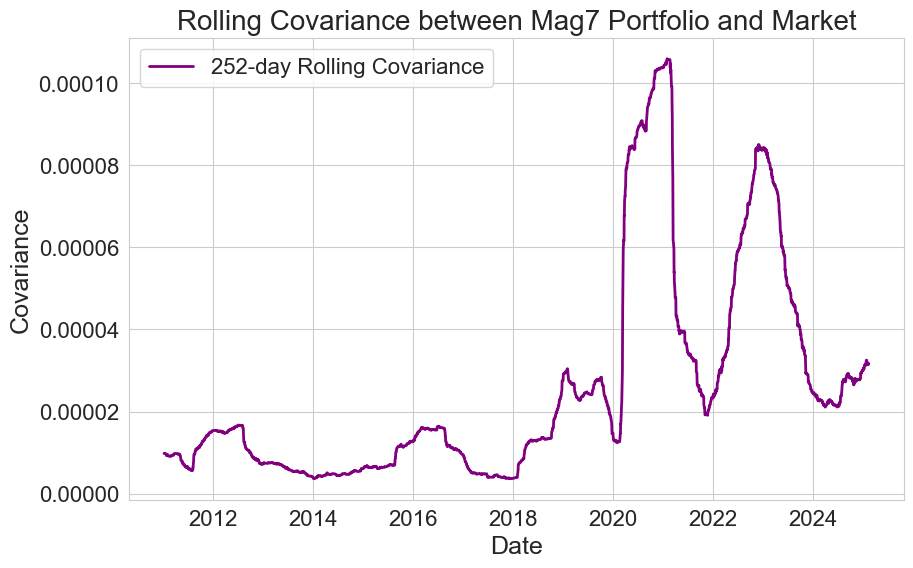

In [29]:
import matplotlib.pyplot as plt

# Compute the 252-day rolling covariance between the Mag7 portfolio returns and the overall market returns.
rolling_cov = df_m7_return.rolling(window=252).cov(df_index_return)

# Create a figure and an Axes object, then plot the rolling covariance.
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(rolling_cov.index, rolling_cov, label="252-day Rolling Covariance", color='purple', linewidth=2)

# Set axis labels and title with increased font sizes.
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Covariance", fontsize=18)
ax.set_title("Rolling Covariance between Mag7 Portfolio and Market", fontsize=20)

# Increase the tick label sizes.
ax.tick_params(axis='both', which='major', labelsize=16)

# Increase the legend font size.
ax.legend(loc="best", fontsize=16)
ax.grid(True)

plt.show()


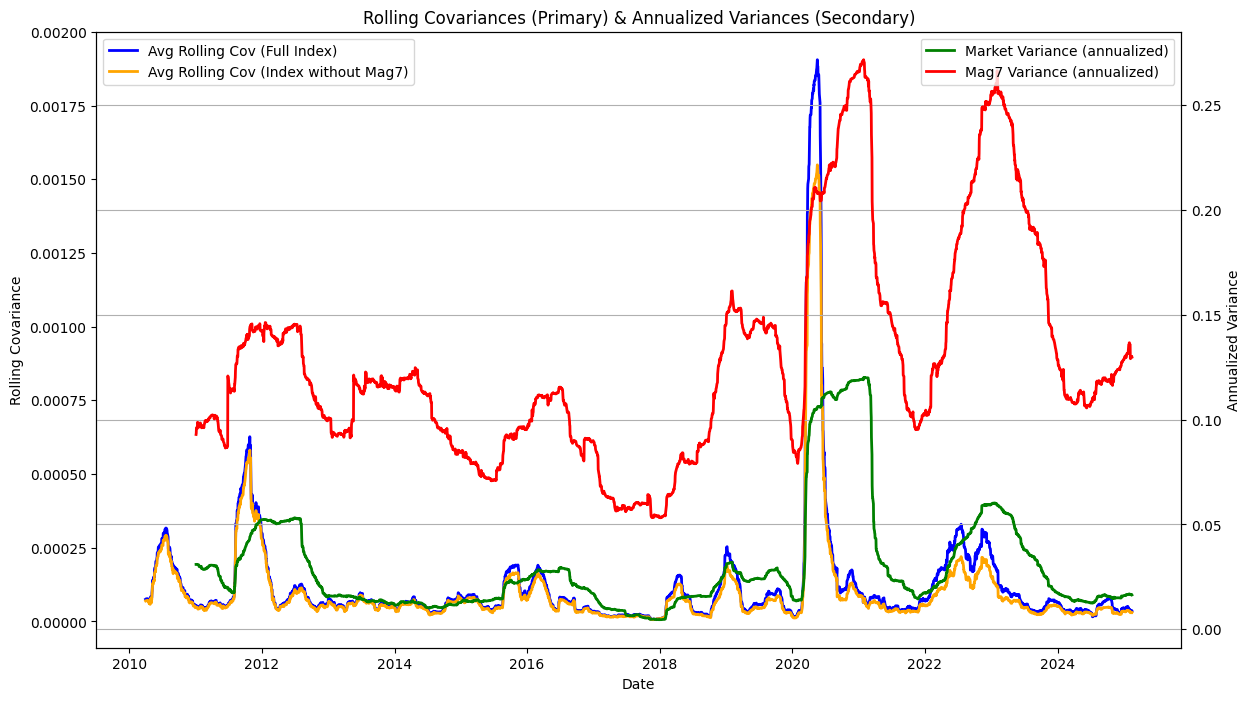

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure reproducibility
random.seed(42)
rolling_window = 60

# Randomly select 20 tickers from non-dominant stocks (other_tickers)
sample_tickers = random.sample(other_tickers, 20)

# Compute rolling covariances for each sampled ticker
rolling_cov_full = pd.DataFrame(index=df_returns.index)
rolling_cov_no_mag7 = pd.DataFrame(index=df_returns.index)
for ticker in sample_tickers:
    rolling_cov_full[ticker] = df_returns[ticker].rolling(window=rolling_window).cov(df_index_return)
    rolling_cov_no_mag7[ticker] = df_returns[ticker].rolling(window=rolling_window).cov(df_others_return)

# Average the rolling covariances across the sampled tickers
avg_cov_full = rolling_cov_full.mean(axis=1)
avg_cov_no_mag7 = rolling_cov_no_mag7.mean(axis=1)

# Compute annualized volatility for the full market and for Mag7 stocks
vol_market = df_index_return.rolling(252).std() * np.sqrt(252)
vol_mag7 = df_returns[m7_tickers].rolling(252).std().mean(axis=1) * np.sqrt(252)
# Convert volatility to variance (annualized)
var_market = vol_market ** 2
var_mag7 = vol_mag7 ** 2

# Plot the rolling covariances on the primary axis and the variances on the secondary axis.
fig, ax1 = plt.subplots(figsize=(14,8))

# Primary axis: rolling covariances
ax1.plot(avg_cov_full.index, avg_cov_full, label="Avg Rolling Cov (Full Index)", color="blue", linewidth=2)
ax1.plot(avg_cov_no_mag7.index, avg_cov_no_mag7, label="Avg Rolling Cov (Index without Mag7)", color="orange", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Rolling Covariance", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.legend(loc="upper left")

# Secondary axis: annualized variances
ax2 = ax1.twinx()
ax2.plot(var_market.index, var_market, label="Market Variance (annualized)", color="green", linewidth=2)
ax2.plot(var_mag7.index, var_mag7, label="Mag7 Variance (annualized)", color="red", linewidth=2)
ax2.set_ylabel("Annualized Variance", color="black")
ax2.tick_params(axis='y', labelcolor="black")
ax2.legend(loc="upper right")

plt.title("Rolling Covariances (Primary) & Annualized Variances (Secondary)")
plt.grid(True)
plt.show()


C:\Users\gigan\AppData\Local\Temp\ipykernel_21964\4058487895.py:31: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_contribution = contribution_df.resample('Y').sum()


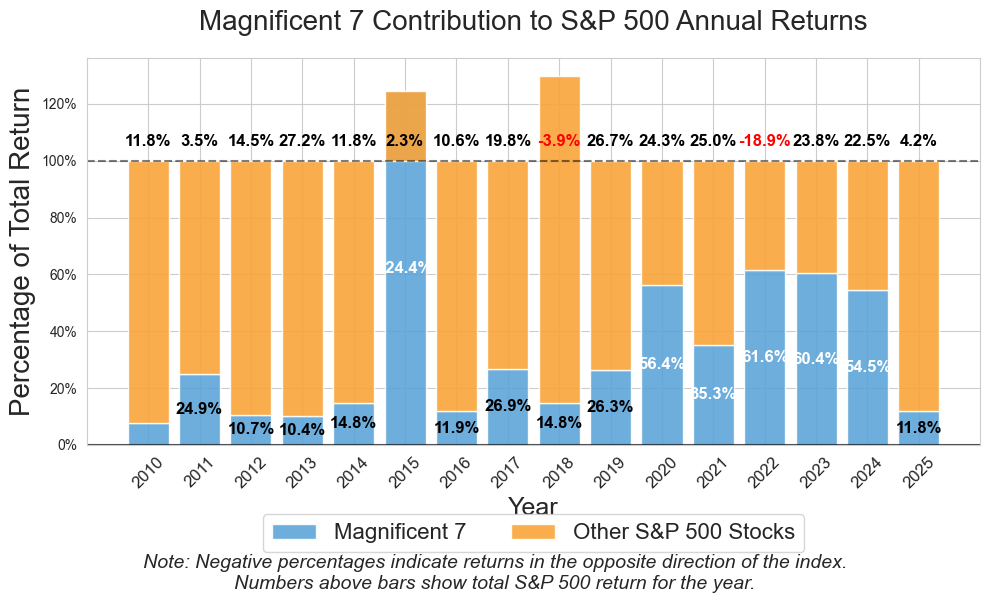

Yearly Contribution Analysis:
            Year  Total_Index  M7_Contribution  Other_Contribution  \
Date                                                                 
2010-12-31  2010        11.78             0.93               10.86   
2011-12-31  2011         3.48             0.87                2.61   
2012-12-31  2012        14.51             1.55               12.96   
2013-12-31  2013        27.15             2.81               24.34   
2014-12-31  2014        11.78             1.74               10.04   
2015-12-31  2015         2.27             2.82               -0.55   
2016-12-31  2016        10.63             1.26                9.37   
2017-12-31  2017        19.84             5.33               14.51   
2018-12-31  2018        -3.90             0.58               -4.48   
2019-12-31  2019        26.68             7.02               19.67   
2020-12-31  2020        24.32            13.71               10.61   
2021-12-31  2021        25.00             8.82              

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

# Calculate daily index returns using weights and individual stock returns
def calculate_index_returns(returns_df, weights_df):
    # Element-wise multiplication of returns and weights
    weighted_returns = returns_df.multiply(weights_df)
    # Sum across all stocks to get the index return for each day
    index_returns = weighted_returns.sum(axis=1)
    return index_returns, weighted_returns

# Get the original data
daily_returns, daily_weighted_returns = calculate_index_returns(df_returns, df_weights)

# Calculate M7 and non-M7 contributions
m7_weighted_returns = daily_weighted_returns[m7_tickers]
m7_contribution = m7_weighted_returns.sum(axis=1)
non_m7_contribution = daily_returns - m7_contribution

# Create a DataFrame with total, M7, and non-M7 returns
contribution_df = pd.DataFrame({
    'Total_Index': daily_returns,
    'M7_Contribution': m7_contribution,
    'Other_Contribution': non_m7_contribution
})

# Resample to yearly returns (sum daily returns within each year)
yearly_contribution = contribution_df.resample('Y').sum()

# Calculate the percentage contribution of M7 to total returns
yearly_contribution['M7_Percentage'] = yearly_contribution['M7_Contribution'] / yearly_contribution['Total_Index'] * 100
yearly_contribution['Other_Percentage'] = yearly_contribution['Other_Contribution'] / yearly_contribution['Total_Index'] * 100

# Handle years where the total index return is negative:
for year in yearly_contribution.index:
    if yearly_contribution.loc[year, 'Total_Index'] < 0:
        yearly_contribution.loc[year, 'M7_Percentage'] = (yearly_contribution.loc[year, 'M7_Contribution'] / 
                                                          abs(yearly_contribution.loc[year, 'Total_Index'])) * 100 * np.sign(yearly_contribution.loc[year, 'M7_Contribution'])
        yearly_contribution.loc[year, 'Other_Percentage'] = (yearly_contribution.loc[year, 'Other_Contribution'] / 
                                                            abs(yearly_contribution.loc[year, 'Total_Index'])) * 100 * np.sign(yearly_contribution.loc[year, 'Other_Contribution'])

# Create a more readable year label (just the year, not datetime)
yearly_contribution['Year'] = yearly_contribution.index.year

# Plot the results with increased font sizes
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = plt.subplot(111)
bars1 = ax.bar(yearly_contribution['Year'], yearly_contribution['M7_Percentage'], 
               label='Magnificent 7', color='#5da5da', alpha=0.9)
bars2 = ax.bar(yearly_contribution['Year'], yearly_contribution['Other_Percentage'], 
               bottom=yearly_contribution['M7_Percentage'].clip(lower=0), 
               label='Other S&P 500 Stocks', color='#faa43a', alpha=0.9)

# Add horizontal lines at 100% and 0%
plt.axhline(y=100, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)

# Add total return markers above the bars with increased font size
for i, year in enumerate(yearly_contribution['Year']):
    total_return = yearly_contribution.loc[yearly_contribution['Year'] == year, 'Total_Index'].values[0] * 100
    plt.annotate(f'{total_return:.1f}%', 
                 xy=(year, 105), 
                 ha='center', 
                 fontweight='bold',
                 color='black' if total_return >= 0 else 'red',
                 fontsize=12)

# Add contribution percentage annotations inside the bars with increased font size
for i, bar in enumerate(bars1):
    height = bar.get_height()
    if abs(height) > 10:  # Show percentage only if sufficiently large
        plt.text(bar.get_x() + bar.get_width()/2., 
                 height/2, 
                 f'{height:.1f}%', 
                 ha='center', va='center', 
                 color='white' if abs(height) > 30 else 'black',
                 fontweight='bold',
                 fontsize=12)

# Customize plot labels, title, and ticks with larger fonts
plt.title('Magnificent 7 Contribution to S&P 500 Annual Returns', fontsize=20, pad=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Percentage of Total Return', fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=16)
plt.xticks(yearly_contribution['Year'], rotation=45, fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.figtext(0.5, 0.01, 
           'Note: Negative percentages indicate returns in the opposite direction of the index.\nNumbers above bars show total S&P 500 return for the year.', 
           ha='center', fontsize=14, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

# Print the numerical results for reference
print("Yearly Contribution Analysis:")
display_cols = ['Year', 'Total_Index', 'M7_Contribution', 'Other_Contribution', 
                'M7_Percentage', 'Other_Percentage']
display_df = yearly_contribution[display_cols].copy()
display_df[['Total_Index', 'M7_Contribution', 'Other_Contribution']] *= 100  # Convert to percentage
print(display_df.round(2))


Tesla significant drop date in 2024: 2024-07-24 00:00:00
Average Index Beta 5 days before drop: 1.0619034350042198
Average Index Beta 5 days after drop: 1.0590617040685895


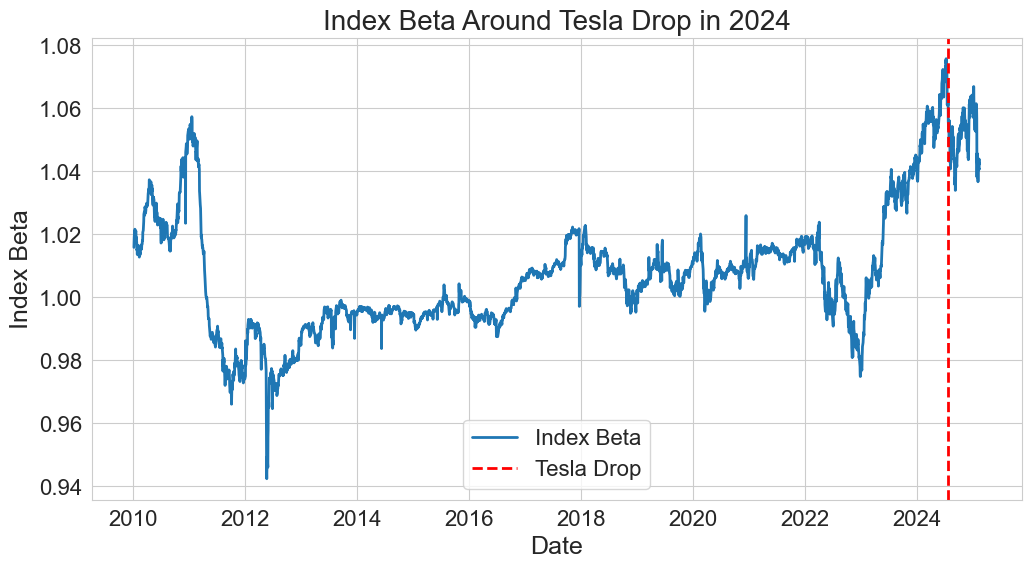

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Identify Tesla drop events in 2024 with daily return below -5%
tsla_drop_events = df_returns["TSLA"][(df_returns.index.year == 2024) & (df_returns["TSLA"] < -0.05)]
if not tsla_drop_events.empty:
    # Choose the most extreme drop event as an example
    tsla_drop_date = tsla_drop_events.idxmin()
    print("Tesla significant drop date in 2024:", tsla_drop_date)

    # Calculate average index beta in a short window before and after the drop event
    window = pd.Timedelta(days=5)
    beta_before = df_analysis.loc[tsla_drop_date - window : tsla_drop_date].mean()["Index_Beta"]
    beta_after  = df_analysis.loc[tsla_drop_date : tsla_drop_date + window].mean()["Index_Beta"]

    print("Average Index Beta 5 days before drop:", beta_before)
    print("Average Index Beta 5 days after drop:", beta_after)

    # Plot the index beta with a vertical line indicating the Tesla drop
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_analysis.index, df_analysis["Index_Beta"], label="Index Beta", linewidth=2)
    ax.axvline(tsla_drop_date, color='red', linestyle='--', linewidth=2, label="Tesla Drop")
    ax.set_xlabel("Date", fontsize=18)
    ax.set_ylabel("Index Beta", fontsize=18)
    ax.set_title("Index Beta Around Tesla Drop in 2024", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16)
    ax.grid(True)
    plt.show()
else:
    print("No Tesla drop event found in 2024 with return below -5%.")


Average beta for non-Mag7 stocks using full index: 1.031
Average beta for non-Mag7 stocks using index without Mag7: 1.350


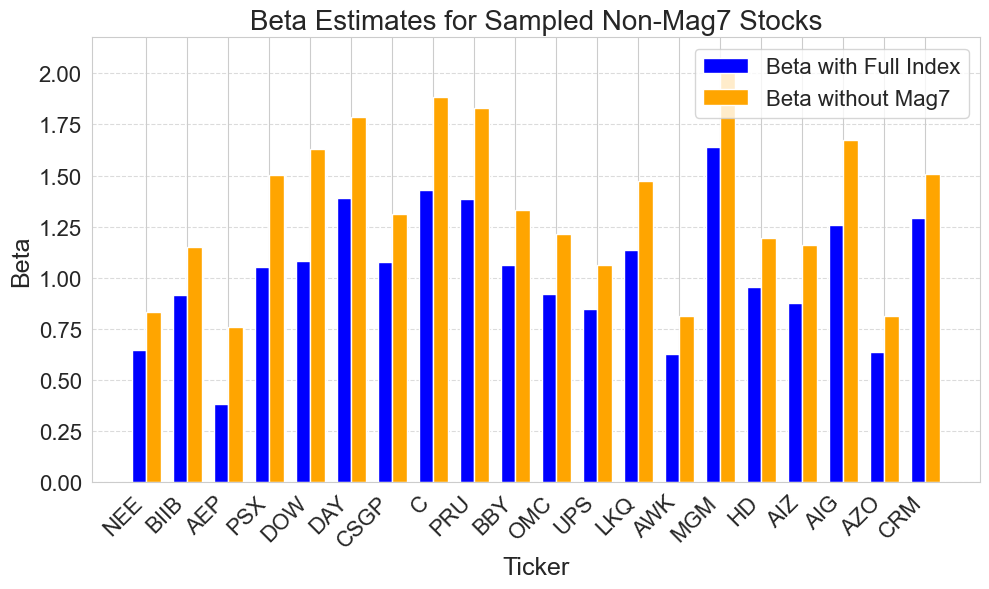

In [27]:
import random
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure reproducibility for random sampling
random.seed(42)

# Randomly select 20 non‑Mag7 tickers for analysis.
sampled_tickers = random.sample(other_tickers, 20)

def compute_beta(company_series, market_series):
    # Align the two series and drop missing values.
    df_temp = pd.concat([company_series, market_series], axis=1).dropna()
    X = sm.add_constant(df_temp.iloc[:, 1])
    y = df_temp.iloc[:, 0]
    model = sm.OLS(y, X).fit()
    return model.params.iloc[1]

# Compute beta for each ticker using the full index and the index without Mag7.
betas_full = {}
betas_no_mag7 = {}
for ticker in sampled_tickers:
    beta_full = compute_beta(df_returns[ticker], df_index_return)
    beta_no_mag7 = compute_beta(df_returns[ticker], df_others_return)
    betas_full[ticker] = beta_full
    betas_no_mag7[ticker] = beta_no_mag7

# Compute average beta across the sampled tickers for each market proxy.
avg_beta_full = np.mean(list(betas_full.values()))
avg_beta_no_mag7 = np.mean(list(betas_no_mag7.values()))

print("Average beta for non-Mag7 stocks using full index: {:.3f}".format(avg_beta_full))
print("Average beta for non-Mag7 stocks using index without Mag7: {:.3f}".format(avg_beta_no_mag7))

# Plotting: Create a grouped bar chart for the beta estimates.
tickers = list(sampled_tickers)
betas_full_list = [betas_full[ticker] for ticker in tickers]
betas_no_mag7_list = [betas_no_mag7[ticker] for ticker in tickers]

x = np.arange(len(tickers))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, betas_full_list, width, label='Beta with Full Index', color='blue')
rects2 = ax.bar(x + width/2, betas_no_mag7_list, width, label='Beta without Mag7', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(tickers, rotation=45, ha='right', fontsize=16)
ax.set_xlabel("Ticker", fontsize=18)
ax.set_ylabel("Beta", fontsize=18)
ax.set_title("Beta Estimates for Sampled Non-Mag7 Stocks", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc="best", fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Correlation between rolling 180-day average correlation and Mag7 cumulative returns: 0.31390293302054584


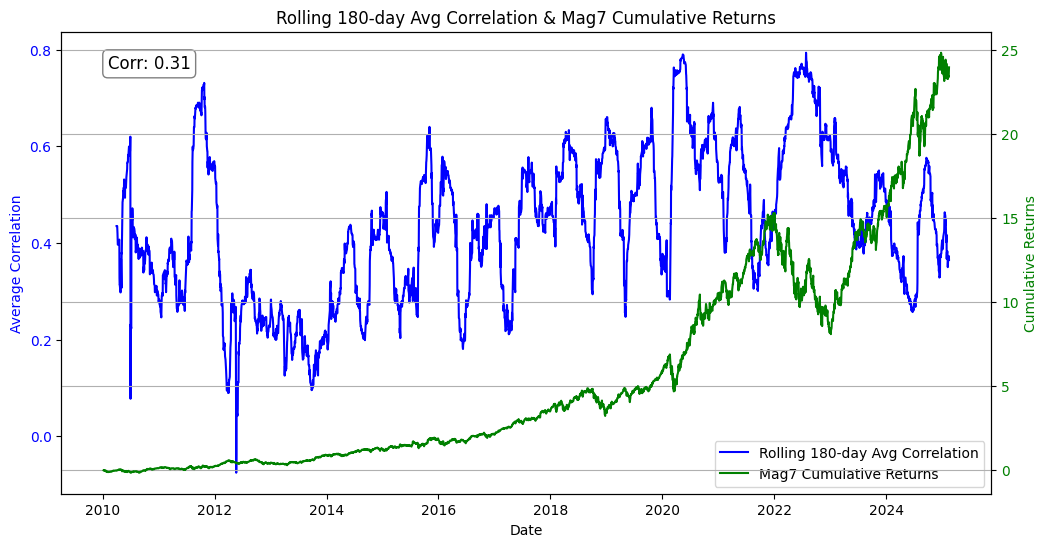

In [ ]:
# %% [code]
# Set rolling window to 180 days
rolling_window = 60

# Extract Mag7 returns (using the cleaned DataFrame and m7_tickers list)
df_mag7 = df_returns[m7_tickers]

# Compute the rolling average pairwise correlation for the Mag7
import numpy as np
avg_corr = []
dates = []

for i in range(rolling_window - 1, len(df_mag7)):
    window_data = df_mag7.iloc[i - rolling_window + 1: i + 1]
    corr_matrix = window_data.corr()
    # Get the unique pairwise correlations (upper triangle without the diagonal)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_pairwise_corr = upper_triangle.stack().mean()
    avg_corr.append(avg_pairwise_corr)
    dates.append(df_mag7.index[i])

# Create a Series for the rolling average correlation
df_avg_corr = pd.Series(avg_corr, index=dates, name="Avg_M7_Correlation")

# %% [code]
# Compute the Mag7 weighted average daily returns
df_mag7_weighted_return = (df_returns[m7_tickers] * df_weights[m7_tickers]).sum(axis=1) / df_weights[m7_tickers].sum(axis=1)

# Compute the cumulative return from the daily weighted returns
df_mag7_cum_return = (1 + df_mag7_weighted_return).cumprod() - 1

# %% [code]
# Compute the correlation between cumulative return and rolling average correlation
# Align the two series on their common dates
common_idx = df_avg_corr.index.intersection(df_mag7_cum_return.index)
corr_value = df_avg_corr.loc[common_idx].corr(df_mag7_cum_return.loc[common_idx])
print("Correlation between rolling 180-day average correlation and Mag7 cumulative returns:", corr_value)

# %% [code]
# Plot both the rolling average correlation and the cumulative returns on the same plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the rolling 180-day average correlation on the primary y-axis
line1, = ax1.plot(df_avg_corr.index, df_avg_corr, color='blue', label='Rolling 180-day Avg Correlation')
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Correlation", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Annotate the computed correlation on the plot
ax1.text(0.05, 0.95, f'Corr: {corr_value:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Create a secondary y-axis for the cumulative returns
ax2 = ax1.twinx()
line2, = ax2.plot(df_mag7_cum_return.index, df_mag7_cum_return, color='green', label='Mag7 Cumulative Returns')
ax2.set_ylabel("Cumulative Returns", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine the legends from both plots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title("Rolling 180-day Avg Correlation & Mag7 Cumulative Returns")
plt.grid(True)
plt.show()

In [ ]:
# %% [code]
from statsmodels.tsa.stattools import adfuller

# Drop any missing values from the rolling correlation series
rolling_corr_series = df_avg_corr.dropna()

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(rolling_corr_series)

# Print the test results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation hint:
if adf_result[1] < 0.05:
    print("\nThe p-value is less than 0.05, which suggests the series is stationary.")
else:
    print("\nThe p-value is greater than 0.05, which suggests the series is non-stationary.")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.1018
p-value: 0.0010
Critical Values:
   1%: -3.4321
   5%: -2.8623
   10%: -2.5672

The p-value is less than 0.05, which suggests the series is stationary.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     5.316
Date:                Tue, 25 Feb 2025   Prob (F-statistic):             0.0263
Time:                        18:05:00   Log-Likelihood:                 123.09
No. Observations:                  43   AIC:                            -242.2
Df Residuals:                      41   BIC:                            -238.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.005      0.534      0.5

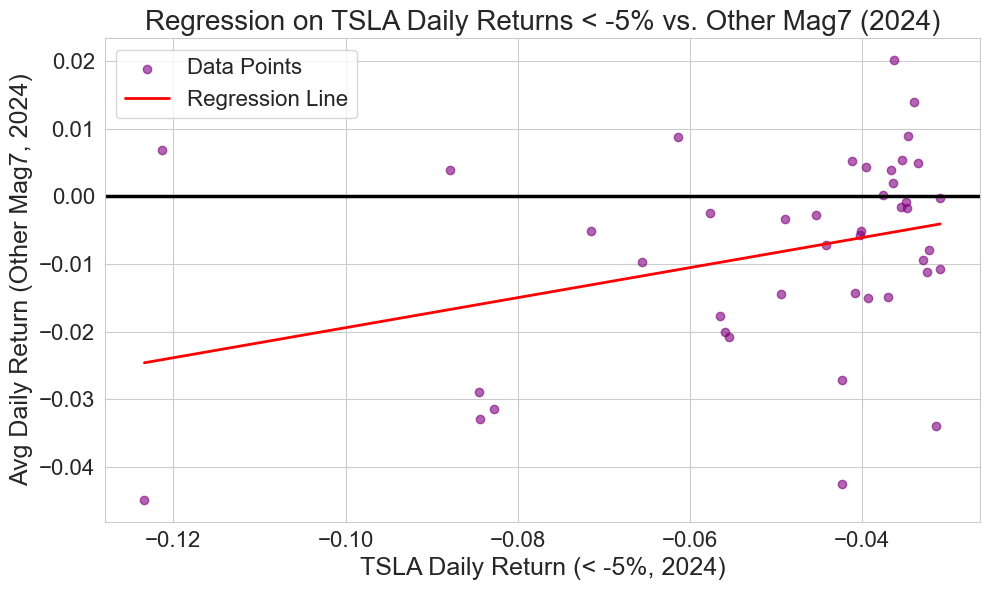

In [62]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Filter the data for 2024 only
tsla_2024 = tsla_daily.loc['2024-01-01':'2024-12-31']
others_2024 = others_daily.loc['2024-01-01':'2024-12-31']

# Further filter to include only days when TSLA's daily return is lower than -5%
threshold = -0.03
tsla_neg_2024 = tsla_2024[tsla_2024 < threshold]
others_neg_2024 = others_2024[tsla_2024 < threshold]  # aligning dates with tsla_neg_2024

# Prepare regression data: TSLA negative returns as independent variable
X = sm.add_constant(tsla_neg_2024)  # add constant for intercept
y = others_neg_2024

# Fit the OLS regression model on the filtered data
model_2024_neg = sm.OLS(y, X).fit()

# Print the regression summary
print(model_2024_neg.summary())

# Plot the scatter plot and the regression line for the filtered data
plt.figure(figsize=(10,6))
plt.scatter(tsla_neg_2024, others_neg_2024, color="purple", alpha=0.6, label="Data Points")
predicted_2024 = model_2024_neg.predict(X)

# Sort the values for a smooth regression line
sorted_idx = np.argsort(tsla_neg_2024)
plt.plot(tsla_neg_2024.iloc[sorted_idx], predicted_2024.iloc[sorted_idx], color="red", linewidth=2, label="Regression Line")

# Add a thick horizontal line at y=0 to separate negative and positive returns
plt.axhline(0, color='black', linewidth=2.5)

plt.xlabel("TSLA Daily Return (< -5%, 2024)", fontsize=18)
plt.ylabel("Avg Daily Return (Other Mag7, 2024)", fontsize=18)
plt.title("Regression on TSLA Daily Returns < -5% vs. Other Mag7 (2024)", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


Tesla significant drop date in 2024: 2024-07-24 00:00:00
Average Rolling Beta 5 days before Tesla drop: 0.8362912163079224
Average Rolling Beta 5 days after Tesla drop: 0.7373705394821826


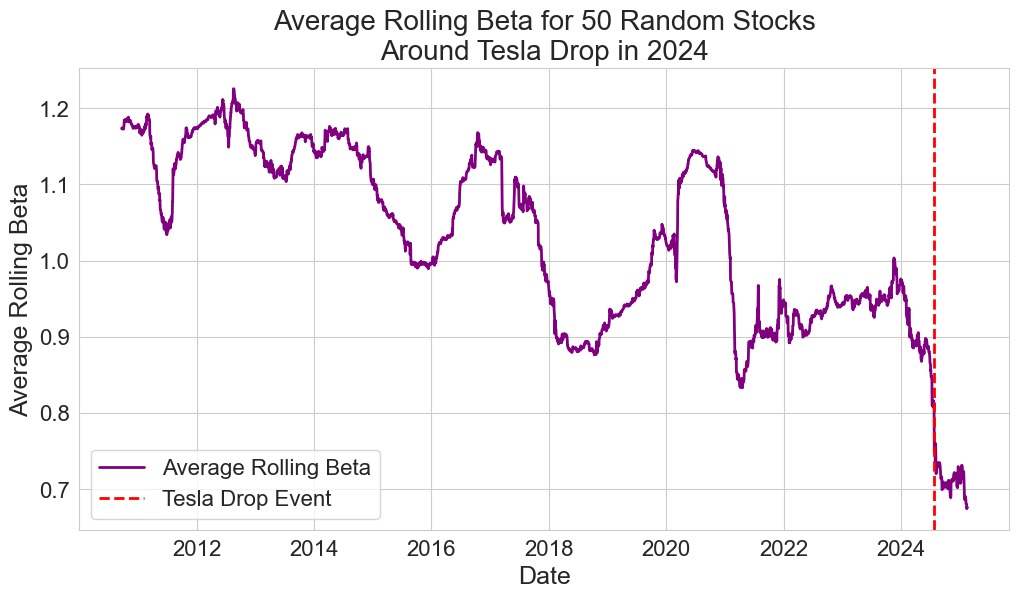

In [47]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure reproducibility
random.seed(42)

# Select 20 random tickers from the list of non-dominant stocks (other_tickers)
sampled_tickers = random.sample(other_tickers, 50)

# Rolling window (in days)
window = 180

# Helper function: Compute beta over a window (using numpy covariance and variance)
def rolling_beta_func(window_data):
    # window_data is a 2D numpy array with two columns:
    # column 0: stock returns, column 1: market returns.
    # Compute variance of market returns:
    var_market = np.var(window_data[:, 1])
    if var_market == 0:
        return np.nan
    cov = np.cov(window_data[:, 0], window_data[:, 1])[0, 1]
    return cov / var_market

# For each sampled ticker, compute the rolling beta series relative to the full index.
rolling_beta_df = pd.DataFrame(index=df_returns.index)

for ticker in sampled_tickers:
    # Combine the stock returns and index returns into one DataFrame
    combined = pd.concat([df_returns[ticker], df_index_return], axis=1)
    combined.columns = ['stock', 'market']
    # We'll compute rolling beta manually (using a loop) because we want a single scalar per window.
    beta_values = []
    dates = []
    for i in range(window - 1, len(combined)):
        window_data = combined.iloc[i - window + 1:i + 1].values  # shape (window, 2)
        beta_val = rolling_beta_func(window_data)
        beta_values.append(beta_val)
        dates.append(combined.index[i])
    # Create a Series for this ticker's rolling beta and store it in our DataFrame
    ticker_beta = pd.Series(beta_values, index=dates)
    rolling_beta_df[ticker] = ticker_beta

# Compute the average rolling beta across the sampled tickers (simple arithmetic average)
avg_rolling_beta = rolling_beta_df.mean(axis=1)

# Identify a Tesla drop event in 2024: days when TSLA return is below -5%
tsla_drop_events = df_returns["TSLA"][(df_returns.index.year == 2024) & (df_returns["TSLA"] < -0.05)]
if not tsla_drop_events.empty:
    tsla_drop_date = tsla_drop_events.idxmin()
    print("Tesla significant drop date in 2024:", tsla_drop_date)
    
    # Define a window of 5 days before and after the event
    window_days = pd.Timedelta(days=30)
    beta_before = avg_rolling_beta.loc[tsla_drop_date - window_days : tsla_drop_date].mean()
    beta_after  = avg_rolling_beta.loc[tsla_drop_date : tsla_drop_date + window_days].mean()
    print("Average Rolling Beta 5 days before Tesla drop:", beta_before)
    print("Average Rolling Beta 5 days after Tesla drop:", beta_after)
else:
    tsla_drop_date = None
    print("No Tesla drop event found in 2024 with return below -5%.")

# Plot the average rolling beta over time with a vertical line marking Tesla drop event.
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(avg_rolling_beta.index, avg_rolling_beta, label="Average Rolling Beta", color='purple', linewidth=2)
if tsla_drop_date is not None:
    ax.axvline(tsla_drop_date, color='red', linestyle='--', linewidth=2, label="Tesla Drop Event")
ax.set_xlabel("Date", fontsize=18)
ax.set_ylabel("Average Rolling Beta", fontsize=18)
ax.set_title("Average Rolling Beta for 50 Random Stocks\nAround Tesla Drop in 2024", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)
ax.grid(True)
plt.show()


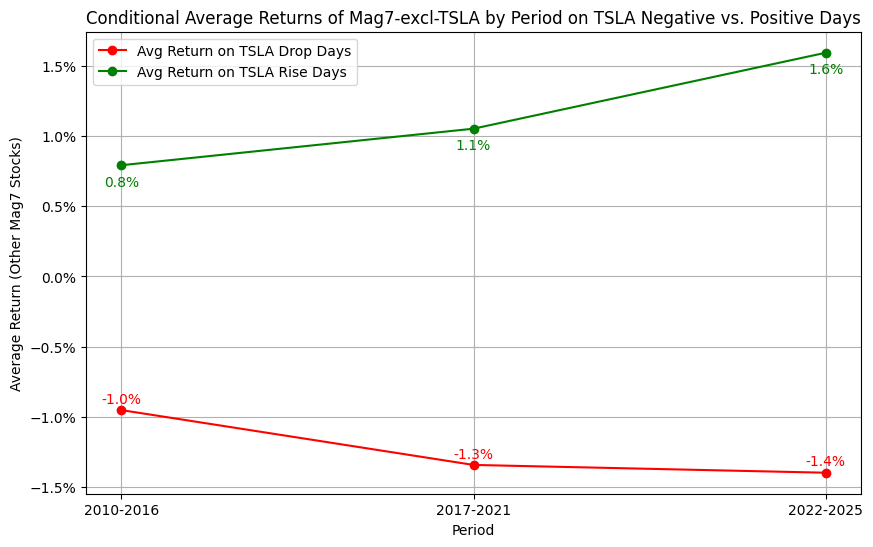

,Drop,Rise
2010-2016,-0.0095,0.0079
2017-2021,-0.0134,0.0105
2022-2025,-0.0140,0.0159


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Define thresholds for TSLA events
neg_threshold = -0.03  # TSLA drop: -3% or lower
pos_threshold =  0.03  # TSLA rise: +3% or higher

# Identify the other Magnificent 7 stocks (excluding TSLA)
other_mag7 = [ticker for ticker in m7_tickers if ticker != "TSLA"]

# Define the three periods as a dictionary mapping period label to (start_date, end_date)
periods = {
    "2010-2016": ("2010-01-01", "2016-12-31"),
    "2017-2021": ("2017-01-01", "2021-12-31"),
    "2022-2025": ("2022-01-01", "2025-12-31")
}

# Initialize dictionaries to store the conditional average returns for each period
avg_return_drop = {}
avg_return_rise = {}

# Loop over the periods and calculate the conditional averages
for period_label, (start_date, end_date) in periods.items():
    # Filter data for the current period
    df_period = df_returns.loc[start_date:end_date]
    
    # Ensure TSLA exists in this period (if not, set to None)
    if "TSLA" not in df_period.columns:
        avg_return_drop[period_label] = None
        avg_return_rise[period_label] = None
        continue
    
    # Identify TSLA drop and rise days in this period
    tsla_drop_days = df_period["TSLA"][df_period["TSLA"] <= neg_threshold].index
    tsla_rise_days = df_period["TSLA"][df_period["TSLA"] >= pos_threshold].index
    
    # Compute the average return for the other Mag7 stocks on these days (if any)
    if len(tsla_drop_days) > 0:
        avg_drop = df_period.loc[tsla_drop_days, other_mag7].mean(axis=1).mean()
    else:
        avg_drop = None
        
    if len(tsla_rise_days) > 0:
        avg_rise = df_period.loc[tsla_rise_days, other_mag7].mean(axis=1).mean()
    else:
        avg_rise = None
        
    avg_return_drop[period_label] = avg_drop
    avg_return_rise[period_label] = avg_rise

# Create a DataFrame from the results
df_periodic = pd.DataFrame({
    "Drop": pd.Series(avg_return_drop),
    "Rise": pd.Series(avg_return_rise)
})

# Plot the conditional average returns for each period on one graph
plt.figure(figsize=(10,6))
line_drop = plt.plot(df_periodic.index, df_periodic["Drop"], marker='o', linestyle='-', color='red', label="Avg Return on TSLA Drop Days")
line_rise = plt.plot(df_periodic.index, df_periodic["Rise"], marker='o', linestyle='-', color='green', label="Avg Return on TSLA Rise Days")

# Format y-axis in percent with 1 decimal point
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1))

plt.xlabel("Period")
plt.ylabel("Average Return (Other Mag7 Stocks)")
plt.title("Conditional Average Returns of Mag7-excl-TSLA by Period on TSLA Negative vs. Positive Days")
plt.legend()
plt.grid(True)

# Annotate each data point with its value in percent (1 decimal place)
for period_label in df_periodic.index:
    drop_val = df_periodic.loc[period_label, "Drop"]
    rise_val = df_periodic.loc[period_label, "Rise"]
    # Annotate drop value if available
    if pd.notnull(drop_val):
        plt.annotate(f"{drop_val*100:.1f}%", 
                     (period_label, drop_val), 
                     textcoords="offset points", 
                     xytext=(0,5), 
                     ha='center', color='red')
    # Annotate rise value if available
    if pd.notnull(rise_val):
        plt.annotate(f"{rise_val*100:.1f}%", 
                     (period_label, rise_val), 
                     textcoords="offset points", 
                     xytext=(0,-15), 
                     ha='center', color='green')

plt.show()

# Display the table of conditional average returns by period (rounded for clarity)
display(df_periodic.round(4))